# Step 1) Pytorch, Auto-encoder, MNIST
---
In this notebook, we will train an auto-encoder to represent images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

```
Run the following cell to import the necessary libraries to work with the data and PyTorch.
```

In [1]:
# import libraries
import os
import operator
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
###
from torch import Tensor
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
###
from typing import Optional, Union
from tqdm import tqdm
from functools import reduce
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
###
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.5.1
Torchvision version: 0.20.1
Numpy version: 1.26.4


---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

The two cells bellow will create DataLoaders for each of our datasets.

```
Run the two cells below to create DataLoaders for each of the training, validation, and test datasets.
```

In [2]:
# Define a method to Scale the intensity of the input data between minv and maxv
class ScaleIntensity:
    def __init__(self, minv=0.0, maxv=1.0):
        self.minv = minv
        self.maxv = maxv

    def __call__(self, img):
        img_min, img_max = img.min(), img.max()
        img = (img - img_min) / (img_max - img_min)
        img = img * (self.maxv - self.minv) + self.minv
        return img

In [3]:
# how many samples per batch to load
batch_size = 64
train_valid_ratio = 0.8

# define intensity range for each input data to perform image normalization 
minv = 0    
maxv = 1

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(padding=2),
    ScaleIntensity(minv=minv, maxv=maxv)
])

# Path to store MNIST dataset
data_dir = "data/MNIST"

# Checks if data has already been downloaded
download = not os.path.exists(data_dir)

# choose the training and test datasets
train_dataset = datasets.MNIST(root='data', train=True, download=download, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=download, transform=transform)

# Split the train_data into a train (80%) and valid (20%) subdataset
train_size = int(train_valid_ratio * len(train_dataset))      # 80% for training
valid_size = len(train_dataset) - train_size    # 20% for validation
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")


Training dataset size: 48000
Validation dataset size: 12000
Test dataset size: 10000


- <span style="color:red">What is the role of the function ScaleIntensity() ?</span>
- <span style="color:red">What is the role of the function transforms.Compose() ?</span>
- <span style="color:red">What is the size of each dataset, and what percentage of the total dataset does it represent?</span>


### Visualize a Batch of Training Data

It's always important to check the accuracy of the data before going any further.

```
Run the cell below to display a subset of the training dataset and the size of a batch
```

The image batch size is (64, 1, 32, 32)


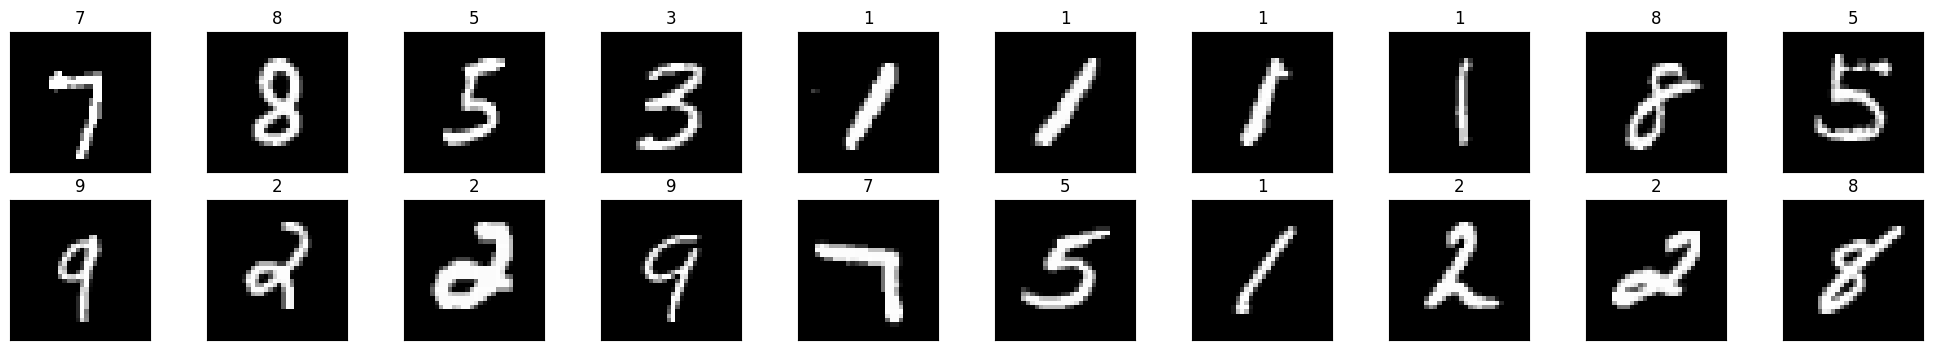

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
print(f"The image batch size is {images.shape}")

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

- <span style="color:red">The size of a batch corresponds to (64, 1, 32, 32). What does each dimension of this batch correspond to ?</span>

### View an Image in More Detail

```
Run the cell below to display an image with the value of each pixel. This will enable you to check the operations performed by the transforms.Compose() function.
```

The size of an image from the dataset is (32, 32)


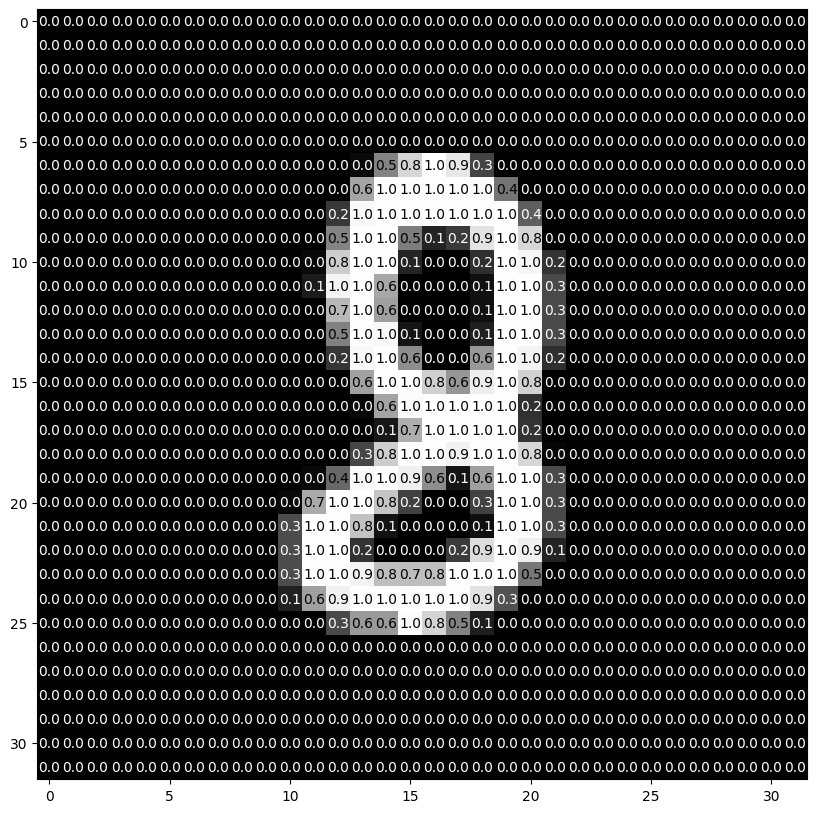

In [5]:
img = np.squeeze(images[1])
print(f"The size of an image from the dataset is {img.shape}")

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(f"{val:.1f}", xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

- <span style="color:red">Modify the code to resample pixel values between -1 and 5</span>
- <span style="color:red">Remodify the code to resample pixel values between 0 and 1</span>

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The process will be broken down into the following steps:
1. Load and visualize the data
> 2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

```
Run the 4 cells below to define in pytorch two networks:
1) encoder: encodes the input data, i.e. project the input data to a latent space with reduced dimensionalities
2) decoder: decodes a sample from the latent space to the image space
```

In [6]:
# Parameters
spatial_dims = 2
in_shape = (32, 32)
out_channels = 1
latent_size = 2
channels = (16, 32, 64)
strides = (1, 2, 2)

In [7]:
# define the encoder
class Encoder(nn.Module):
    def __init__(self, in_shape, channels, strides, latent_size):
        super(Encoder, self).__init__()
        # define the convolutional layers for downsampling and feature
        # extraction
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=strides[0], padding=1)
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=strides[1], padding=1)
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=strides[2], padding=1)
        # define a flatten layer to flatten the tensor before feeding it into
        # the fully connected layer
        self.flatten = nn.Flatten()
        # define fully connected layers to transform the tensor into the desired
        # embedding dimensions
        last_feature_size = np.zeros(2)
        last_feature_size[0] = in_shape[0] // (reduce(operator.mul, strides))
        last_feature_size[1] = in_shape[1] // (reduce(operator.mul, strides))
        last_feature_size = np.array(last_feature_size, dtype=int)
        intermediate_size = channels[2] * last_feature_size[0] * last_feature_size[1]
        self.fc = nn.Linear(intermediate_size, latent_size)
        
    def forward(self, x):
        # apply convolutional layers with relu activation function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten the tensor
        x = self.flatten(x)
        # get the corresponding latent vector
        z = self.fc(x)
        return z
    
    
# define the decoder
class Decoder(nn.Module):
    def __init__(self, in_shape, channels, strides, latent_size):
        super(Decoder, self).__init__()
        # define a fully connected layer to transform the latent vector back to
        # the shape before flattening        
        last_encoder_feature_size = np.zeros(2)
        last_encoder_feature_size[0] = in_shape[0] // (reduce(operator.mul, strides))
        last_encoder_feature_size[1] = in_shape[1] // (reduce(operator.mul, strides))
        last_encoder_feature_size = np.array(last_encoder_feature_size, dtype=int)
        intermediate_size = channels[2] * last_encoder_feature_size[0] * last_encoder_feature_size[1]
        self.fc = nn.Linear(latent_size,intermediate_size)
        # define a reshape function to reshape the tensor back to its original
        # shape
        shape_before_flattening = (channels[2], last_encoder_feature_size[0], last_encoder_feature_size[1])
        self.reshape = lambda x: x.view(-1, *shape_before_flattening)
        # define the transposed convolutional layers for the decoder to upsample
        # and generate the reconstructed image
        self.deconv1 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=strides[2], padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=strides[1], padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(channels[0], 1, 3, stride=strides[0], padding=1, output_padding=0)

    def forward(self, x):
        # pass the latent vector through the fully connected layer
        x = self.fc(x)
        # reshape the tensor
        x = self.reshape(x)
        # apply transposed convolutional layers with relu activation function
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        # apply the final transposed convolutional layer with a sigmoid
        # activation to generate the final output
        x = torch.sigmoid(self.deconv3(x))
        return x
    
    
# define the vae class
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        # initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        # pass the input through the encoder to get the latent vector
        z = self.encoder(x)
        # pass the latent vector through the decoder to get the reconstructed
        # image
        reconstruction = self.decoder(z)
        # return the mean, log variance and the reconstructed image
        return reconstruction, z

# Instantiate the encoder and decoder models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(in_shape, channels, strides, latent_size).to(device)
decoder = Decoder(in_shape, channels, strides, latent_size).to(device)
# pass the encoder and decoder to VAE class
model = AE(encoder, decoder).to(device)


In [8]:
# Print the summary of the encoder network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=3, verbose=0
)
summary(encoder, (1, 1, 32, 32), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
Encoder                                  [1, 1, 32, 32]            [1, 2]                    --                        --
├─Conv2d: 1-1                            [1, 1, 32, 32]            [1, 16, 32, 32]           [3, 3]                    160
├─Conv2d: 1-2                            [1, 16, 32, 32]           [1, 32, 16, 16]           [3, 3]                    4,640
├─Conv2d: 1-3                            [1, 32, 16, 16]           [1, 64, 8, 8]             [3, 3]                    18,496
├─Flatten: 1-4                           [1, 64, 8, 8]             [1, 4096]                 --                        --
├─Linear: 1-5                            [1, 4096]                 [1, 2]                    --                        8,194
Total params: 31,490
Trainable params: 31,490
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.54
Input size (MB): 0.0

In [9]:
# Print the summary of the decoder network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=3, verbose=0
)
summary(decoder, (1, 1, 2), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
Decoder                                  [1, 1, 2]                 [1, 1, 32, 32]            --                        --
├─Linear: 1-1                            [1, 1, 2]                 [1, 1, 4096]              --                        12,288
├─ConvTranspose2d: 1-2                   [1, 64, 8, 8]             [1, 32, 16, 16]           [3, 3]                    18,464
├─ConvTranspose2d: 1-3                   [1, 32, 16, 16]           [1, 16, 32, 32]           [3, 3]                    4,624
├─ConvTranspose2d: 1-4                   [1, 16, 32, 32]           [1, 1, 32, 32]            [3, 3]                    145
Total params: 35,521
Trainable params: 35,521
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 9.62
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.14
Estimated Total Size (MB): 0.38

- <span style="color:red">Draw the detailed architecture of the encoder and decoder on a sheet of paper, showing the characteristic values (filter size, spatial dimensions, number of feature maps) for each layer.</span>
- <span style="color:red">How many parameters do the encoder and decoder have in total?</span>
- <span style="color:red">For each encoder and decoder layer, calculate the number of parameters to be matched and check your results with the values displayed by the summary() functions.</span>

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

```
Run the cell below to define the loss function and the optimize scheme
```

In [10]:
## Specify loss and optimization functions
learning_rate = 0.001

def loss_function(x_reconstructed, x):
    loss = nn.BCELoss() # Binary cross entropy function
    # loss = nn.L1Loss()
    return loss(x_reconstructed, x)

# Specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


- <span style="color:red">Why the BCE sounds to be a good choice to reconstruct the MNIST images ?</span>

---
## Train the Network

The process will be broken down into the following steps:
1. Load and visualize the data
2. Define a neural network
> 3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

```
Run the cell below to train the network. The following loop trains for 5 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 
```

In [11]:
# Number of epochs to train the model
n_epochs = 5

# Move the model to the device
model = model.to(device)

# Lists to store loss and accuracy for each epoch
train_loss_list = []
valid_metric_list = []

best_valid_metric = float('inf')  # to track the best validation loss
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    # monitor training loss
    model.train()  # ensure the model is in training mode
    recon_metric = 0    
    
    ###################
    # train the model #
    ###################
    for batch_data in train_loader:
        # Load data and target samples stored the current batch_data
        inputs = batch_data[0].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        recon_batch, _ = model(inputs)
        # calculate the loss
        loss = loss_function(recon_batch, inputs)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        recon_metric += loss.item() * inputs.size(0)
                
    # Calculate average training loss and accuracy over the epoch
    train_loss_list.append(recon_metric / len(train_loader.dataset))

    ###################
    # Validation step #
    ###################    
    model.eval()  # set model to evaluation mode
    valid_metric = 0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            inputs = batch_data[0].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            recon, _ = model(inputs)
            # calculate the loss
            valid_metric += loss_function(recon, inputs).item() * inputs.size(0)

    # Compute average validation loss and accuracy
    valid_metric_list.append(valid_metric / len(valid_loader.dataset))
        
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss_list[-1]:.6f} \tValidation metric: {valid_metric_list[-1]:.6f}')

    # Save the model if it has the best validation loss
    if valid_metric_list[-1] < best_valid_metric:
        best_valid_metric = valid_metric_list[-1]
        best_model = model.state_dict()
        best_epoch = epoch + 1  # Save the epoch number
        

# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')  # Save the best model

print(f"Best model selected at epoch {best_epoch} with validation metric: {best_valid_metric:.6f}")


Epoch: 1 	Training Loss: 0.186460 	Validation metric: 0.165119
Epoch: 2 	Training Loss: 0.160455 	Validation metric: 0.158178
Epoch: 3 	Training Loss: 0.155275 	Validation metric: 0.153871
Epoch: 4 	Training Loss: 0.152311 	Validation metric: 0.151340
Epoch: 5 	Training Loss: 0.150300 	Validation metric: 0.150084
Best model selected at epoch 5 with validation metric: 0.150084


- <span style="color:red">Analyze each line of this code and read the associated comments.</span>
- <span style="color:red">What does the best saved model represent ?</span>

---
## Evaluate the performance of our trained model on a test dataset

The process will be broken down into the following steps:
1. Load and visualize the data
2. Define a neural network
3. Train the model
> 4. Evaluate the performance of our trained model on a test dataset

```
Run the cell below to display the evolution of the training loss and the validation metric curves to investigate the success of the learning process
```


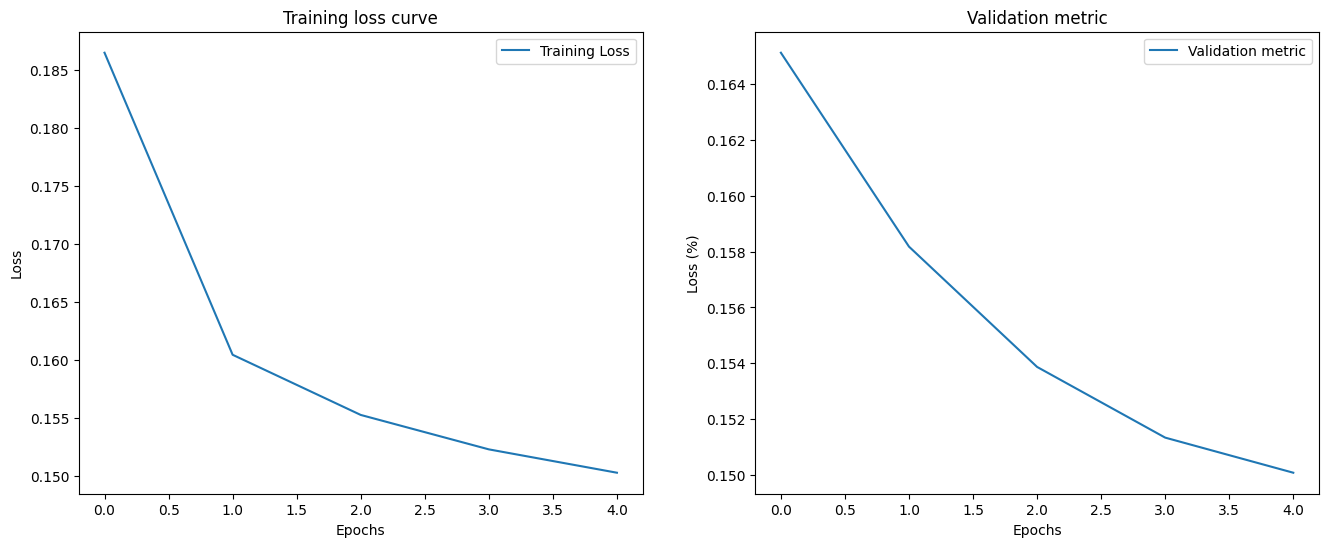

In [12]:
# Plot loss curves
plt.figure(figsize=(16, 6))

# Plotting global loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation metric
plt.subplot(1, 2, 2)
plt.plot(valid_metric_list, label='Validation metric')
plt.title('Validation metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()


- <span style="color:red">What are your conclusions based on the analysis of these two curves ?</span>
- <span style="color:red">Modify the previous code to improve the training process, that is, to achieve better values for the validation metric.</span>

### Compute the overall performance on the test dataset

We then test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well.

model.eval() will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

```
Run the cell below to compute the scores of the trained network on the test dataset
```

In [13]:
# initialize lists to monitor test loss and accuracy
test_metric = 0.0
model.eval() # prep model for *evaluation*

with torch.no_grad():  # disable gradient calculation during validation
    for batch_data in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        inputs = batch_data[0].to(device)
        recon, _ = model(inputs)
        # calculate the loss
        loss = loss_function(recon.float(), inputs.float())
        test_metric += loss.item() * inputs.size(0)
    
# calculate and print avg test loss
test_metric = test_metric / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_metric))

# Prepare next cell
dataiter = iter(test_loader)

Test Loss: 0.149527



- <span style="color:red">Compare the scores obtained on the validation data and the test data. Conclusions?</span>

### Visualize Sample Test Results

```
Run the cell below to display reconstructed images taken from the test dataset in the following order: reference image (left) and reconstructed one (right), i.e. the output of the auto-encoder network.
```

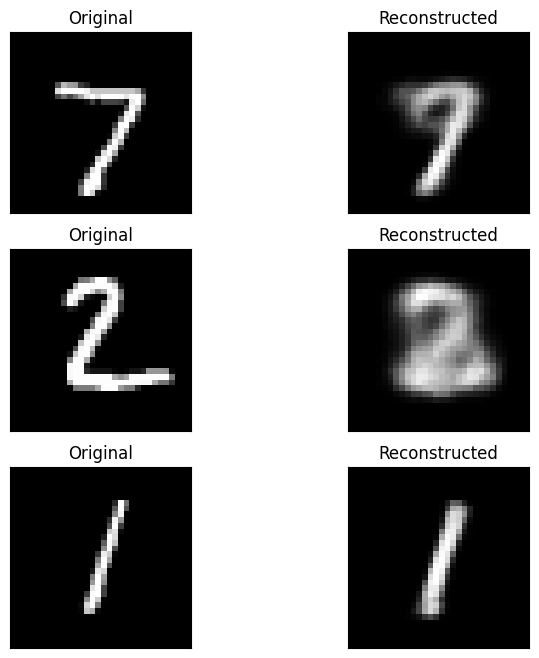

In [14]:
# obtain one batch of test images
batch_data = next(dataiter)

# get sample outputs
inputs = batch_data[0].to(device)
recons, _ = model(inputs)
# reconstruction images for display
recons = recons.detach().cpu().numpy()
inputs = inputs.detach().cpu().numpy()

# Plot the image, label and prediction
fig = plt.figure(figsize=(8, 8))
for idx in range(3):
    ax = fig.add_subplot(3, 2, 2*idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(inputs[idx]), cmap='gray')
    ax.set_title('Original')
    ax = fig.add_subplot(3, 2, 2*idx+2, xticks=[], yticks=[])
    ax.imshow(np.squeeze(recons[idx]), cmap='gray')
    ax.set_title('Reconstructed')


- <span style="color:red">What are you conclusions?</span>

### Display latent space !

It can be useful to display the latent space to investigate its structure.

```
Run the cells below to compute and display the latent space
```

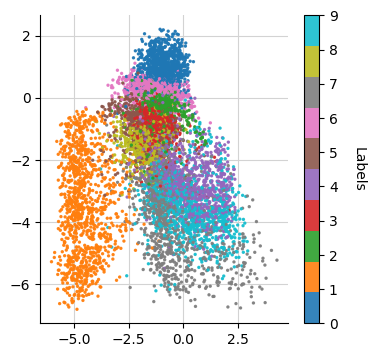

In [15]:
def get_test_embeddings(test_loader, encoder):
    # switch the model to evaluation mode
    encoder.eval()
    # initialize empty lists to store the embeddings and labels
    points = []
    label_idcs = []
    # iterate through the test loader
    for i, data in enumerate(test_loader):
        # move the images and labels to the appropriate device
        img, label = [d.to(device) for d in data]
        # encode the test images using the encoder
        z = encoder(img)
        # convert the embeddings and labels to NumPy arrays
        # and append them to the respective lists
        points.extend(z.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        # free up memory by deleting the images and labels
        del img, label
    # convert the embeddings and labels to NumPy arrays
    points = np.array(points)
    label_idcs = np.array(label_idcs)
    # return the embeddings and labels to the calling function
    return points, label_idcs


def plot_latent_space(test_loader, encoder, show=False):
    # get the embeddings and labels for the test images
    points, label_idcs = get_test_embeddings(test_loader, encoder)
    # create a new figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 8) if not show else (4, 4))
    # create a scatter plot of the embeddings, colored by the labels
    scatter = ax.scatter(
        x=points[:, 0],
        y=points[:, 1],
        s=2.0,
        c=label_idcs,
        cmap="tab10",
        alpha=0.9,
        zorder=2,
    )
    # remove the top and right spines from the plot
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # add a colorbar to the plot
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.ax.set_ylabel("Labels", rotation=270, labelpad=20)
    # if show is True, display the plot
    if show:
        # add a grid to the plot
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        # plt.show()
    # otherwise, save the plot to a file and close the figure
    else:
        plt.savefig("latent_space.png", bbox_inches="tight")
        plt.close()
        
plot_latent_space(test_loader, encoder, show=True)
  

- <span style="color:red">What does the latent space represent ?</span>
- <span style="color:red">Analyze and interpret the latent space obtained ?</span>

### Plot random images

Now it is time to test the capacity of generating new synthetic digits. This is done in two steps:
1) samples directly from the latent space;
2) use the decoder to project the sample into the image space to generate the synthetic image.

```
Run the cell below to compute and display the latent space from a grid of points sampled directed from the latent space
```

/tmp/ipykernel_41288/1370339093.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("rainbow", num_classes)


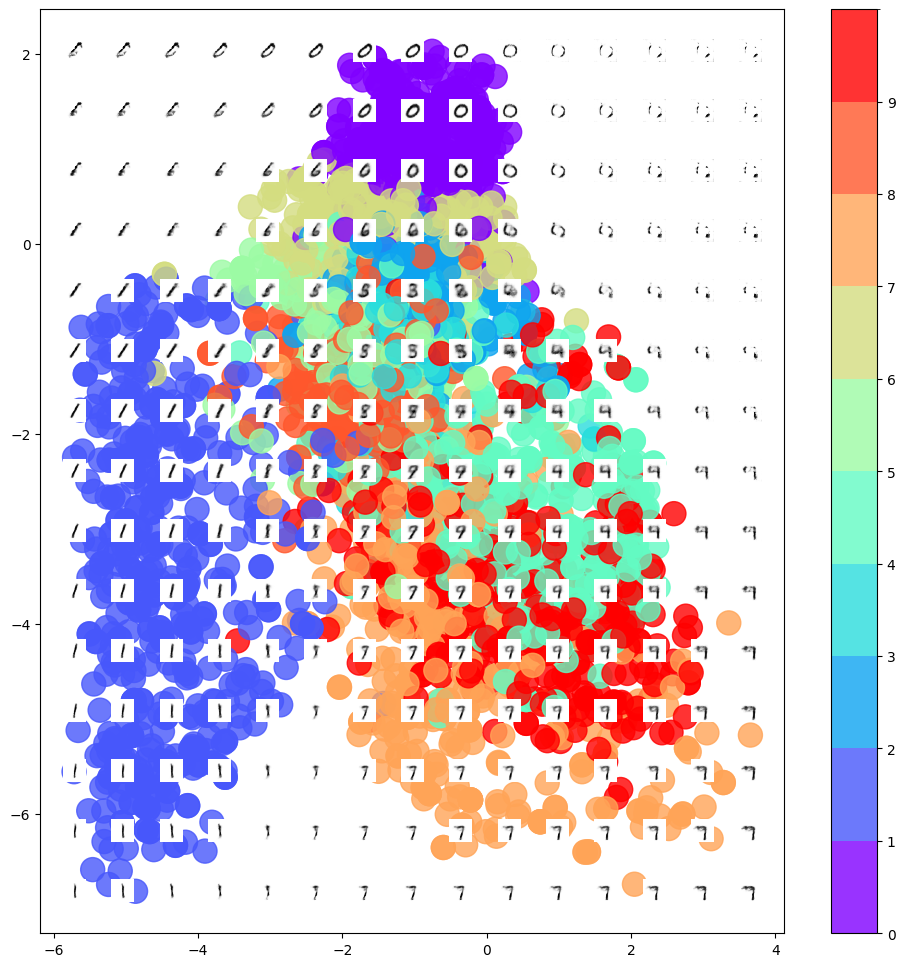

In [16]:
def get_random_test_images_embeddings(test_loader, encoder, imgs_visualize=5000):
    # get all the images and labels from the test loader
    all_images, all_labels = [], []
    for batch in test_loader:
        images_batch, labels_batch = batch
        all_images.append(images_batch)
        all_labels.append(labels_batch)
    # concatenate all the images and labels into a single tensor
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    # randomly select a subset of the images and labels to visualize
    index = np.random.choice(range(len(all_images)), imgs_visualize)
    images = all_images[index]
    labels = all_labels[index]
    # get the embeddings for all the test images
    points, _ = get_test_embeddings(test_loader, encoder)
    # select the embeddings corresponding to the randomly selected images
    embeddings = points[index]
    # return the randomly selected images, their labels, and their embeddings
    return images, labels, embeddings

def plot_image_grid_on_embeddings(
    test_loader, encoder, decoder, grid_size=15, figsize=12, show=True
):
    # get a random subset of test images
    # and their corresponding embeddings and labels
    _, labels, embeddings = get_random_test_images_embeddings(test_loader, encoder)
    # create a single figure for the plot
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    # define a custom color map with discrete colors for each unique label
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    cmap = cm.get_cmap("rainbow", num_classes)
    bounds = np.linspace(0, num_classes, num_classes + 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    # Plot the scatter plot of the embeddings colored by label
    scatter = ax.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        cmap=cmap,
        c=labels,
        norm=norm,
        alpha=0.8,
        s=300,
    )
    # Create the colorbar with discrete ticks corresponding to unique labels
    cb = plt.colorbar(scatter, ticks=range(num_classes), spacing="proportional", ax=ax)
    cb.set_ticklabels(unique_labels)
    # Create the grid of images to overlay on the scatter plot
    x = np.linspace(embeddings[:, 0].min(), embeddings[:, 0].max(), grid_size)
    y = np.linspace(embeddings[:, 1].max(), embeddings[:, 1].min(), grid_size)
    xv, yv = np.meshgrid(x, y)
    grid = np.column_stack((xv.ravel(), yv.ravel()))
    # convert the numpy array to a PyTorch tensor
    # and get reconstructions from the decoder
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    reconstructions = decoder(grid_tensor.to(device))
    # overlay the images on the scatter plot
    for i, (grid_point, img) in enumerate(zip(grid, reconstructions)):
        img = img.squeeze().detach().cpu().numpy()
        imagebox = OffsetImage(img, cmap="Greys", zoom=0.5)
        ab = AnnotationBbox(
            imagebox, grid_point, frameon=False, pad=0.0, box_alignment=(0.5, 0.5)
        )
        ax.add_artist(ab)

    plt.show()
    
plot_image_grid_on_embeddings(test_loader, encoder, decoder, show=True)

- <span style="color:red">Why does the creation of this latent space enable the investigation of the ability to generate new synthetic digits?</span>

### Let's create a cool animation ;)

```
Run the two cells below to generate an animation that allows you to study the properties of latent space. 
```

In [17]:
def get_random_latent_points(range_min=-2, range_max=2, latent_size=2):
    # Générer deux points aléatoires avec des coordonnées comprises entre `range_min` et `range_max`
    point1 = torch.FloatTensor(latent_size).uniform_(range_min, range_max)
    point2 = torch.FloatTensor(latent_size).uniform_(range_min, range_max)
    return point1, point2

def interpolate_images(decoder, point1, point2, steps=10):
    # Interpolate between point1 and point2 in the latent space
    alphas = np.linspace(0, 1, steps)
    interpolated_points = [point1 * (1 - alpha) + point2 * alpha for alpha in alphas]
    interpolated_points = torch.stack(interpolated_points).to(device)
    
    # Pass the interpolated points through the decoder to get reconstructed images
    interpolated_images = decoder(interpolated_points)
    
    # Return images as a list after detaching and converting to numpy
    return [img.squeeze().detach().cpu().numpy() for img in interpolated_images]

def save_animation_as_gif(images, filename="animation.gif", interval=200):
    fig, ax = plt.subplots(figsize = (4,4))
    img_display = ax.imshow(images[0], cmap="gray", vmin=0, vmax=1)
    ax.axis("off")

    def update(frame):
        img_display.set_data(images[frame])
        return [img_display]

    ani = FuncAnimation(fig, update, frames=len(images), interval=interval, blit=True)
    ani.save(filename, writer="pillow", fps=1000//interval)
    plt.close(fig) 


First sampled point in latent space: tensor([-2., -2.])
Last sampled point in latent space: tensor([2., 2.])


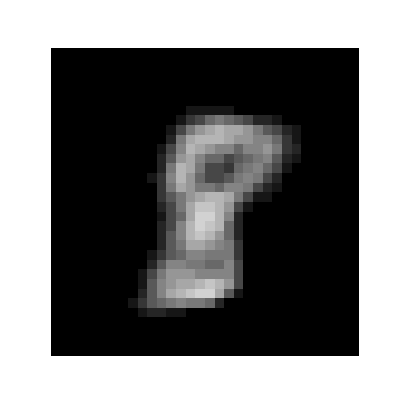

In [18]:
# Randomly select two points in the latent space
random_generation = False

if random_generation:
    # Example to generate deux random points
    point1, point2 = get_random_latent_points(latent_size=latent_size)
else:
    np_array_1 = np.array([-2,-2])
    point1 = torch.tensor(np_array_1, dtype=torch.float32)
    np_array_2 = np.array([2,2])
    point2 = torch.tensor(np_array_2, dtype=torch.float32)
    
print("First sampled point in latent space:", point1)
print("Last sampled point in latent space:", point2)

# Interpolate between the two points and decode to generate images
images = interpolate_images(decoder, point1, point2, steps=60)

# Animate the interpolated images
filename = "mnist_interpolation.gif"
save_animation_as_gif(images, filename=filename, interval=200)

# Affiche le GIF dans Jupyter
display(Image(filename=filename))   

- <span style="color:red">Analyze each line of this code and read the associated comments.</span>
- <span style="color:red">Whate properties of the latent space are investigated thanks to this animation ?</span>

---
## Additional questions

Now that you have mastered this first code, try experimenting with the properties of the network to study their influence on the quality of the results

- <span style="color:red">Evaluate the influence of encoder/decoder architectures (e.g. number of layers, depth) on result quality.</span>
- <span style="color:red">Evaluate the influence of the loss (e.g. BCE vs L1Norm) on result quality.</span>
- <span style="color:red">Evaluate the optimization process (e.g. Adam vs SGD, learning rate) on result quality.</span>